In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
from tqdm import tqdm
from FFNN import FFNN
import csv

from basic_strategy_agent import BasicStrategyAgent
from blackjackenv_extended import BlackjackEnv

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("using gpu: ", torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print("using cpu")

np.random.seed(43)

c:\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


using cpu


## Data Generation

### Simulated Data

In [2]:
def read_data(file):
    return pd.read_csv(file, delimiter=',')

In [3]:
def split_data(data, test_split=True):
    x = data[:, :5]
    y = data[:, 5]
    if test_split:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=37)
    else:
        x_train, x_test, y_train, y_test = x, x, y, y
    return x_train, x_test, y_train, y_test

def transform(data):
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [4]:
def preprocess(filename, test_split=True):
    df_raw = read_data(filename)
    print(df_raw.head())
    d_raw = df_raw.to_numpy() # data to binary?
    x, x_test, y, y_test = split_data(d_raw, test_split)
    x, x_test = transform(x), transform(x_test)
    
    return x, x_test, y, y_test

In [5]:
datafile = '../data/basic_strategy_agent.csv'
x_train, x_test, y_train, y_test = preprocess(datafile)

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0          20            3           0                    1              1   
1          20           10           0                    1              1   
2          17            9           0                    1              0   
3          20            2           0                    1              1   
4          20            3           0                    1              1   

   Action  
0       0  
1       0  
2       0  
3       0  
4       0  


In [6]:
def one_hot_encode(y, n):
    return torch.eye(n)[y]

def combine_input_and_label(x, y, n):
    y_one_hot = one_hot_encode(y, n)
    return torch.concat((x, y_one_hot), 1)

def generate_neg_labels(y, n):
    y_ = y.copy()
    for i in range(len(y)):
        negative_labels = [j for j in range(n) if j != y[i]]
        y_[i] = np.random.choice(negative_labels)

    return y_

In [7]:
x_pos = combine_input_and_label(x_train, y_train, 4)

y_neg = generate_neg_labels(y_train, 4)
x_neg = combine_input_and_label(x_train, y_neg, 4)

y_train_OH = one_hot_encode(y_train, 4)
y_test_OH = one_hot_encode(y_test, 4)


print(f"x_pos[0]: {x_pos[0]}")
print(f"x_neg[0]: {x_neg[0]}")
print(f"Train size: {len(x_train)}")
print(f"Test size: {len(x_test)}")

x_pos[0]: tensor([20., 10.,  0.,  1.,  1.,  1.,  0.,  0.,  0.])
x_neg[0]: tensor([20., 10.,  0.,  1.,  1.,  0.,  1.,  0.,  0.])
Train size: 10
Test size: 3


### Balanced Data

In [21]:
env = BlackjackEnv(natural=True)
basic_strategy_agent = BasicStrategyAgent(env, filename='../data/blackjack_combinations')

def create_combinations():
    for player_hand in range(4, 22):
        for dealer_hand in range(2, 12):
            for usable_ace in range(2):
                for can_double_down in range(2):
                    for can_split in range(2):
                        observation = (player_hand, dealer_hand, usable_ace, can_double_down, can_split)
                        if (dealer_hand == 11 and usable_ace) == 1:
                            # impossible combination
                        
                            continue
                        action = basic_strategy_agent.get_action(observation)
                        basic_strategy_agent.collect_data(observation, action)
    
    basic_strategy_agent.save_data()
                        
            
def get_combinations_for_action(action):
    samples = []
    with open('../data/blackjack_combinations.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            if int(row[-1]) == action:
                samples.append(row)
    return samples

def sample_balanced_data(n_samples):
    data = []
    combinations = np.empty(4, dtype=object)
    
    for action in range(4):
        combinations[action] = get_combinations_for_action(action)
        
        for i in range(n_samples):
            sample_idx = np.random.choice(len(combinations[action]))
            data.append(combinations[action][sample_idx])

    with open('../data/balanced_data.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        
        writer.writerow(["Player sum", "Dealer card", "Usable ace", "Double down allowed", "Split allowed", "Action"])
        writer.writerows(data)

In [9]:
create_combinations()
samples_per_action = 30_000
sample_balanced_data(samples_per_action)

In [32]:
datafile = '../data/blackjack_combinations.csv'
x_train_bal, x_test_bal, y_train_bal, y_test_bal = preprocess(datafile, test_split=False)

x_pos_bal = combine_input_and_label(x_train_bal, y_train_bal, 4)

y_neg_bal = generate_neg_labels(y_train_bal, 4)
x_neg_bal = combine_input_and_label(x_train_bal, y_neg_bal, 4)

y_train_OH_bal = one_hot_encode(y_train_bal, 4)
y_test_OH_bal = one_hot_encode(y_test_bal, 4)


print(f"x_pos[0]: {x_pos_bal[0]}")
print(f"x_neg[0]: {x_neg_bal[0]}")
print(f"Train size: {len(x_train_bal)}")
print(f"Test size: {len(x_test_bal)}")

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0           4            2           0                    0              0   
1           4            2           0                    0              1   
2           4            2           0                    1              0   
3           4            2           0                    1              1   
4           4            2           1                    0              0   

   Action  
0       1  
1       3  
2       1  
3       3  
4       1  
x_pos[0]: tensor([4., 2., 0., 0., 0., 0., 1., 0., 0.])
x_neg[0]: tensor([4., 2., 0., 0., 0., 0., 0., 0., 1.])
Train size: 1368
Test size: 1368


## Forward-Forward

In [17]:
def print_accuracy(model_predictions, y):
    predictions = np.array(torch.Tensor.cpu(model_predictions)).flatten()
    accuracy =  model_predictions.eq(torch.from_numpy(y).to(device)).float().mean().item()
    
    print(y)
    print(predictions)
    print(f'Accuracy: {accuracy}')

    ConfusionMatrixDisplay.from_predictions(y, predictions)

In [10]:
def cross_validation(x_pos, x_neg,architectures, thresholds, learning_rates, n_epochs, n_folds, batch_sizes, lr_decays):
    
    size_subset = len(x_pos) // n_folds
    validation_risks = []
    
    for architecture in tqdm(architectures):
        for threshold in thresholds:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for lr_decay in lr_decays:
                        print(f"Current Model:{architecture}, thr={threshold}, lr={lr}, batch_size={batch_size}, lr_decay={lr_decay}")
                        print("-"*40)
                        val_risks_model = []
                        
                        for fold in range(n_folds):
                            print(f"Fold {fold}")
                            print("-"*40)
                            
                            # Split data into training and validation
                            start_idx = fold * size_subset
                            end_idx = (fold + 1) * size_subset
                            x_pos_train = torch.cat((x_pos[:start_idx], x_pos[end_idx:]))
                            x_neg_train = torch.cat((x_neg[:start_idx], x_neg[end_idx:]))
                            x_val = x_train[start_idx:end_idx]
                            y_val = y_train[start_idx:end_idx]
                            
                            # Initialize current model
                            model = FFNN(
                                device=device,
                                layers=architecture,
                                bias=True,
                                threshold=threshold,
                                learning_rate=lr,
                                epochs=n_epochs,
                                batch_size=batch_size,
                                lr_decay=lr_decay
                            ).to(device)
                            
                            # Train model
                            model.train(x_pos_train, x_neg_train)
                            
                            # Compute validation risk
                            predictions = model.predict_accumulated_goodness(x_val) # juiste risk?
                            val_risk = 1 - predictions.eq(torch.from_numpy(y_val).to(device)).float().mean().item()
                            val_risks_model.append(val_risk)
                            
                            print(f"\n validation risk: {val_risk}")
                            
                        avg_val_risk = np.mean(val_risks_model)
                        validation_risks.append((architecture, threshold, lr, batch_size, lr_decay, avg_val_risk ))
                        #model.save_model(f'../models/model_{architecture}_{threshold}_{lr}_{avg_val_risk}.pth')
                        
                        with open('../data/cxv_results.csv', 'a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow([architecture, threshold, lr, batch_size, lr_decay, avg_val_risk])
                            
                        print("-"*40)
                        print(f"validation risks for model {architecture}, thr={threshold}, lr={lr}: {val_risks_model}")
                        print(f"average validation risk: {avg_val_risk}\n")
    
    print("total validation risks:" , validation_risks)  
    min_risk_model = min(validation_risks, key=lambda x: x[-1])
    print(f"Best model: {min_risk_model}")   
    return min_risk_model               

In [ ]:
# Hyperparameters
architectures = [
    [9,30,30],
    [9,100,100],
    [9,500,500],
    [9,100,100,100],
    [9,200,200,200],
    [9,1000,1000,1000],
    [9,2000,2000,2000,2000],
]
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 3, 5, 7]
learning_rates = [0.0001,0.001,0.01,0.03]
n_epochs = 1000
n_folds = 10
batch_sizes = [64, 500, len(x_train)]
lr_decays = [0, 1]

In [ ]:
best_model = cross_validation(
    x_pos, 
    x_neg, 
    architectures,
    thresholds,
    learning_rates,
    n_epochs,
    n_folds,
    batch_sizes,
    lr_decays
)

In [ ]:
# Best model hyperparameters
architecture_best = best_model[0]
threshold_best = best_model[1]
learning_rate_best = best_model[2]
epochs = 1000
batch_size = best_model[3]
lr_decay = best_model[4]

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay
).to(device)

In [ ]:
model.train(x_pos, x_neg)
model.save_model('../models/best_model.pth')

[2 0 0]
[1 0 0]
Accuracy: 0.6666666865348816


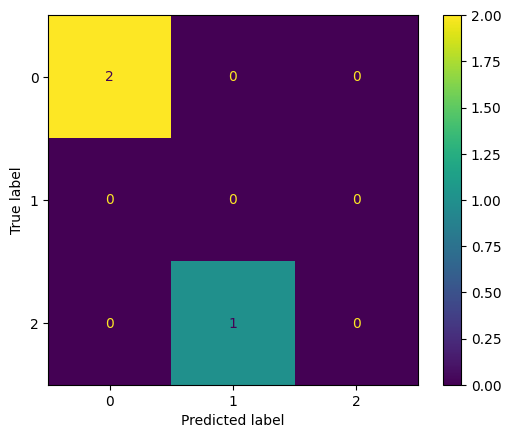

In [18]:
print_accuracy(model.predict_accumulated_goodness(x_test), y_test)


### FFNN with Softmax Classifier

In [9]:
# Best model hyperparameters
architecture_best = [9,100,100,100]
threshold_best = 0.5
learning_rate_best = 0.0001
epochs = 300
batch_size = 1
lr_decay = False

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    classifier=True
).to(device)

model.train(x_pos, x_neg)
model.train_classifier(x_pos, y_train_OH, epochs)
model.save_model('../models/softmax_model.pth')
torch.save(model.classifier.state_dict(), '../models/softmax_model_classifier.pth')

Best model: [9, 100, 100, 100], thr=0.5, lr=0.0001


100%|██████████| 300/300 [00:02<00:00, 141.24it/s]



Training Softmax
----------------------------------------


100%|██████████| 300/300 [00:00<00:00, 2258.58it/s]

Last epoch loss: 1.0433142185211182


tensor([[20., 10.,  0.,  1.,  1.],
        [20.,  3.,  0.,  1.,  1.],
        [21., 10.,  1.,  1.,  0.],
        [17.,  9.,  0.,  1.,  0.],
        [10., 10.,  0.,  1.,  0.],
        [20.,  2.,  0.,  1.,  1.],
        [18.,  8.,  0.,  0.,  0.],
        [13.,  8.,  0.,  1.,  0.],
        [19.,  7.,  1.,  0.,  0.],
        [14.,  7.,  1.,  1.,  0.]])
tensor([[20.0000, 10.0000,  0.0000,  1.0000,  1.0000,  0.2500,  0.2500,  0.2500,
          0.2500],
        [20.0000,  3.0000,  0.0000,  1.0000,  1.0000,  0.2500,  0.2500,  0.2500,
          0.2500],
        [21.0000, 10.0000,  1.0000,  1.0000,  0.0000,  0.2500,  0.2500,  0.2500,
          0.2500],
        [17.0000,  9.0000,  0.0000,  1.0000,  0.0000,  0.2500,  0.2500,  0.2500,
          0.2500],
        [10.0000, 10.0000,  0.0000,  1.0000,  0.0000,  0.2500,  0.2500,  0.2500,
          0.2500],
        [20.0000,  2.0000,  0.0000,  1.0000,  1.0000,  0.2500,  0.2500,  0.2500,
          0.2500],
        [18.0000,  8.0000,  0.0000,  0.0000,  0.0

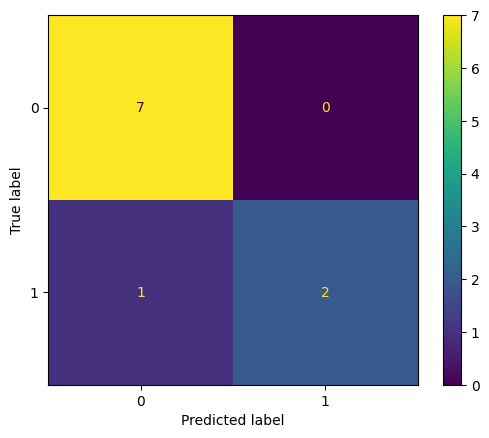

In [19]:
print_accuracy(model.predict_classifier(x_train),y_train)

### Balanced Data FFNN

In [48]:
# Hyperparameters
layers = [9, 2000, 2000, 2000, 2000]
threshold = 6
learning_rate = 0.001
epochs = 120
batch_size = 64
lr_decay = False

model = FFNN(
    device=device,
    layers=layers,
    threshold=threshold,
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    ).to(device)


3000


In [ ]:
model.train(x_pos_bal, x_neg_bal)
model.save_model('../models/model_balanced.pth')

Accuracy: 0.7909356951713562


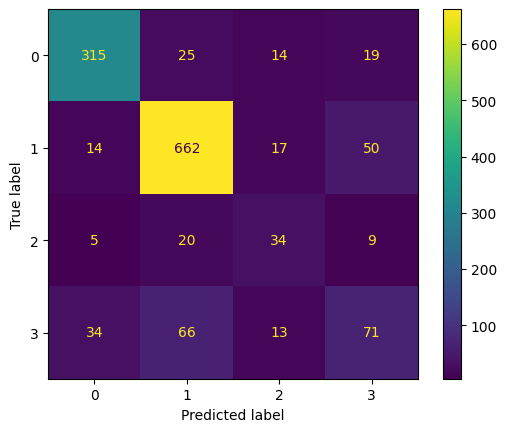

In [46]:
print_accuracy(model.predict_accumulated_goodness(x_test_bal), y_test_bal)

## Backpropagation

In [26]:
def train(model, x, y, epochs, loss_function, optimizer, batch_size):
    
    model.train()
    num_batches = len(x) // batch_size
    
    for epoch in range(epochs):
        losses = []
        for batch in tqdm(range(num_batches)):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f"epoch: {epoch + 1}/{epochs} avg. loss: {sum(losses)/len(losses)}")

In [27]:
def test(model, x_test, y_test, loss_function):
    
    model.eval()
    
    with torch.no_grad():
        predictions = model(x_test)
        test_loss = loss_function(predictions, y_test).item()
        
    print(f"avg. test loss: {test_loss}")   
    
def predict_actions(model, x):
    model.eval()
    
    with torch.no_grad():
        predictions = model(x)
        return predictions.argmax(1)

In [28]:
from backpropNN import BackpropNN

input_size = 5
output_size = 4

# hyperparameters
hidden_size = 30
activation_function = nn.ReLU()

# fully connected neural network with 4 hidden layers
backprop_model = BackpropNN(input_size, output_size, hidden_size, activation_function)

In [32]:
# hyperparameters
epochs = 100
batch_size = 64
learning_rate = 0.001

optimizer = torch.optim.Adam(backprop_model.parameters(), lr=learning_rate);
loss_fn = nn.CrossEntropyLoss()

train(backprop_model, x_train, y_train_OH, epochs, loss_fn, optimizer, batch_size)
torch.save(backprop_model.state_dict(), '../models/backprop_model.pth')

100%|██████████| 26/26 [00:00<00:00, 519.77it/s]


epoch: 1/10 avg. loss: 1.3648410806289086


100%|██████████| 26/26 [00:00<00:00, 806.64it/s]


epoch: 2/10 avg. loss: 1.268617909688216


100%|██████████| 26/26 [00:00<00:00, 812.50it/s]


epoch: 3/10 avg. loss: 1.1571954580453725


100%|██████████| 26/26 [00:00<00:00, 649.74it/s]


epoch: 4/10 avg. loss: 1.072003308397073


100%|██████████| 26/26 [00:00<00:00, 788.24it/s]


epoch: 5/10 avg. loss: 1.028952459876354


100%|██████████| 26/26 [00:00<00:00, 896.65it/s]


epoch: 6/10 avg. loss: 1.009978154530892


100%|██████████| 26/26 [00:00<00:00, 758.64it/s]


epoch: 7/10 avg. loss: 0.9906617953227117


100%|██████████| 26/26 [00:00<00:00, 684.24it/s]


epoch: 8/10 avg. loss: 0.970029585636579


100%|██████████| 26/26 [00:00<00:00, 837.89it/s]


epoch: 9/10 avg. loss: 0.9461542574258951


100%|██████████| 26/26 [00:00<00:00, 896.49it/s]


epoch: 10/10 avg. loss: 0.9243824871686789


In [152]:
test(backprop_model, x_test, y_test_OH, loss_fn)

avg. test loss: 0.9507748484611511


In [153]:
# print(torch.from_numpy(y_test))
# print(predict_action(backprop_model, x_test))
accuracy = predict_actions(backprop_model, x_test).eq(torch.from_numpy(y_test)).float().mean().item() # heet dit accuracy?
print(accuracy)

tensor([0, 1, 1,  ..., 1, 0, 0])
tensor([0, 0, 0,  ..., 0, 0, 0])
0.5006591975688934


## DQFFNN Testing

In [24]:
# DQFFNN hyperparameters
architecture_best = [9,100,100]
threshold_best = 0.5
learning_rate_best = 0.01
epochs = 100
batch_size = 1
lr_decay = False

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay
).to(device)

model.load_model('../models/DQFFNN_model.pth')

Best model: [9, 100, 100], thr=0.5, lr=0.01


Accuracy: 0.7056105732917786


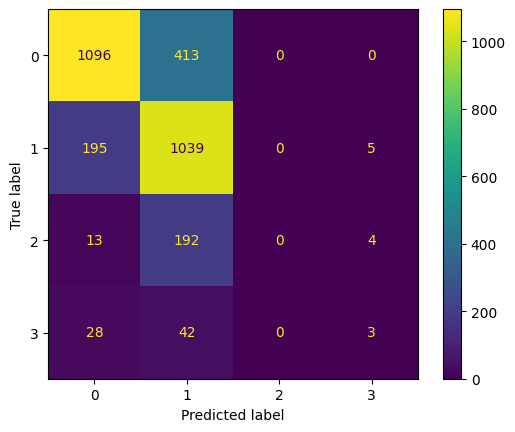

In [25]:
print_accuracy(model.predict_accumulated_goodness(x_test), y_test)